The goal of this analysis will be to predict diamond prices in usd using various regression techniques.
I will use the cliche Kaggle diamond dataset: https://www.kaggle.com/datasets/shivam2503/diamonds.
However, this will be a fresh analysis and not a copy of any tutorial or other published notebook.


I started by getting the set into a DataFrame and checking for duplicate IDs.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

path_to_csv = 'diamonds.csv'

df = pd.read_csv(path_to_csv)
print(df.head())

df = df.rename(columns={'Unnamed: 0': 'id'})
if df['id'].is_unique:
  print('no duplicates found')

print(df.head())

   Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75  
no duplicates found
   id  carat      cut color clarity  depth  table  price     x     y     z
0   1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   5   0.31     Good     J     SI2   63.3   58.0    335  4.34  

I then checked each column for nulls and found none.  Given that regression techniques usually require numerical data, the 3 categorical columns also needed special handling.  I started this by eyeballing the distribution of values in those columns and found nothing that would raise any flags here.  The distributions were hardly uniform, but each value for each variable had at least 500 observations, which applies the law of large numbers

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64


C:\Users\ashby\AppData\Local\Temp\ipykernel_31112\3011198894.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


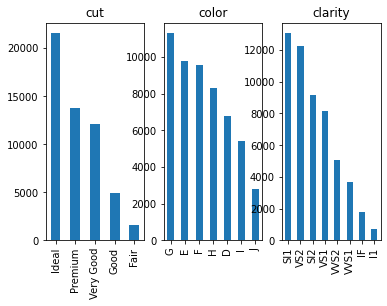

In [7]:
print(df.isna().sum())
categorical_columns = ['cut','color','clarity']

for column in categorical_columns:
  print(df[column].value_counts())

fig, ax = plt.subplots(1, len(categorical_columns))
for i, column in enumerate(df[categorical_columns]):
  df[column].value_counts().plot(kind='bar', ax=ax[i]).set_title(column)
  
fig.show()


As these are all ordinal features, applying plain integer encoding is appropriate.  The color and clarity order are well defined, but the cut is less so.  Fair < Good < Very Good is clear from the [GIA](https://https://www.gia.edu/doc/estimating_cut_grade_chart_lowres.pdf), but premium and ideal are less well documented.  

It should be possible to make an educated guess on this order from comparing their relationship to price while considering the other variables.  Looking at cut alone, it does seem like premium cut diamonds tend towards higher prices.

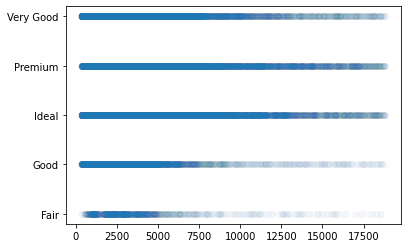

In [9]:
cut_scale = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
df.cut = df.cut.astype('category')
df.cut.cat.set_categories(cut_scale)
df = df.sort_values('cut')

plt.scatter(y=df['cut'], x=df['price'], alpha=0.01)

The average price for Premium cut diamonds is also higher than Ideal cut, but Fair is also higher than Good and the distribution above (plus semantics) suggests otherwise.  There is another influence on the cut/price relationship that needs to be found (or at least searched for).  The obvious route would be to look at the same 2 stats for similar carat sizes.  However, this dataset is well studied and I won't gain anything by going with the obvious, so let's find an empirical route!

In [10]:
df.groupby('cut', as_index=False)['price'].mean()

,cut,price
0,Fair,4358.757764
1,Good,3928.864452
2,Ideal,3457.541970
3,Premium,4584.257704
4,Very Good,3981.759891


In [11]:
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['id', 'carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2'],
      dtype='object')

I need to look at correlations between independent variables.  It would be nice to have an empirical way of ranking the correlations to know which are acceptable.  I couldn't find any methods that did not rely on some sort of guesswork.  For now, I will go with variance inflation factor and the rule of thumb > 5 is worth investigating and 10 is highly correlated.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

drop_price = df.drop(['id','price'], axis = 1)

high_vif_column = []
max_vif = 11

while max_vif >= 10:
  vif_data = pd.DataFrame()
  vif_data['feature'] = drop_price.columns

  vif_data['vif'] = [variance_inflation_factor(drop_price.values, i) 
                     for i in range(len(drop_price.columns))]
  max_vif = max(vif_data['vif'])
  if max_vif > 10:
    max_loc = vif_data.loc[vif_data['vif'] == max_vif]
    max_vif_feature = max_loc['feature'].values[0]
    high_vif_column.append(max_vif_feature)
    drop_price = drop_price.drop(max_vif_feature, axis=1)

print('dropped columns with vifs > 10: ', high_vif_column)
print('current vif scores:')
print(vif_data)
df = df.drop(high_vif_column, axis=1)
df.head()


dropped columns with vifs > 10:  ['x', 'depth', 'y', 'z', 'table', 'cut_Ideal']
current vif scores:
          feature       vif
0           carat  4.648915
1        cut_Good  1.229661
2     cut_Premium  1.644957
3   cut_Very Good  1.538428
4         color_E  2.320527
5         color_F  2.316121
6         color_G  2.637482
7         color_H  2.211607
8         color_I  1.852052
9         color_J  1.479537
10     clarity_IF  1.274871
11    clarity_SI1  3.109927
12    clarity_SI2  2.794975
13    clarity_VS1  2.307734
14    clarity_VS2  2.874504
15   clarity_VVS1  1.540888
16   clarity_VVS2  1.736418


,id,carat,price,cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
3850,3851,1.01,3477,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
26202,26203,1.50,15584,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4207,4208,1.04,3564,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
41432,41433,0.45,1227,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
33758,33759,0.40,840,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


Its not surprising to see that the size columns, x, y, depth and table were removed as hightly correleated with the other values.  These will all be replaced with carat.  Next is outlier detection.  I will compare a few different methods here to a baseline of 2.5 standard deviations from the mean in either direction.  Outliers in interaction terms will not be tracked yet.

In [13]:
import numpy as np

outlier_boundary = 2.5 * np.std(df['carat'])
mean_carat = np.mean(df['carat']) 
mean_carat

0.7979397478680014

I will need to check for all 4 of the linear regression assumptions.  

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html

- Independence: Observations are independent of each other.
- Linearity: The relationship between X and the mean of Y is linear.
- Homoscedasticity: The variance of residual is the same for any value of X.
- Normality: For any fixed value of X, Y is normally distributed.

Independence is an easy one to check off, each observation here is likely a discrete diamond as each row had unique IDs.  Linearity will be next.

In [14]:
from sklearn.linear_model import LinearRegression 

regr = LinearRegression()
regr.fit 

<bound method LinearRegression.fit of LinearRegression()>